<a id='index'> </a>


---

## Table of Contents


1. **[Defining Problem Statement & Data Import](#a)**
    - 1.1 **[Problem Statement](#1.1)**
    - 1.2 **[Importing Libraries](#1.2)**
    - 1.3 **[Importing  , Converting , Copying data to Parquet](#1.3)**







2. **[Exploratory Data Analysis & Visualizations](#2)**

    - 2.1 **[Checking Shape , Number of Unique Values & Datatypes of all Features](#2.1)**
    - 2.2 **[Checking proportion of each category's percentage using Value Counts & Describe](#2.2)**
    - 2.3 **[Checking Missing  and Duplicate Values](#2.3)**
    - 2.4 **[Visualization of outliers using boxplot and correlation using heatmap](#2.4)**

    
    
3. **[Data Pre-processing & Feature Engineering](#3)**
    - 3.1 **[Removing Features & Train Test Split](#3.1)**
    - 3.2 **[Encoding Categorical Columns & Data Oversampling](#3.2)**
    - 3.3 **[Visualization of target variable for train data](#3.3)**
    - 3.4 **[Effective Methods for Outlier Removal](#3.4)** 
        -  3.41 **[DBScan](#3.41)**
        -  3.42 **[Isolation Forest](#3.42)**
        -  3.43 **[Local Outlier Factor](#3.43)**
        -  3.44 **[IQR Method](#3.44)**
        
4. **[Creating Base Model](#4)**
    - 4.1 **[Base Model without outliers](#4.1)**
    - 4.2 **[Base Model with outliers](#4.2)**
    - 4.3 **[KFold Crossvalidation & Randomsearch CV](#4.3)**
    
5. **[Sequential Neural Network Using Keras & TensorFlow](#5)**
    - 5.1 **[Scaling data with standard scaler](#5.1)**
    - 5.2 **[Building Model Architecture](#5.2)**
    - 5.3 **[Model with outliers](#5.3)**
    - 5.4 **[Leading Questions:](#5.4)**
        - 5.5.1 **[Data cleaning including missing values, outliers and multi-collinearity.](#5.5.1)**
        - 5.5.2 **[Describe your fraud detection model in elaboration.](#5.5.2)**
        - 5.5.3 **[How did you select variables to be included in the model?](#5.5.3)**
        - 5.5.4 **[Demonstrate the performance of the model by using best set of tools](#5.5.4)**
        - 5.5.5 **[What are the key factors that predict fraudulent customer?](#5.5.5)**
        - 5.5.6 **[Do these factors make sense? If yes, How? If not, How not?](#5.5.6)**
        - 5.5.7 **[What kind of prevention should be adopted while company update its infrastructure?](#5.5.7)**
        - 5.5.8 **[Assuming these actions have been implemented, how would you determine if they work?](#5.5.8)**

6. **[Conclusion](#6)**


    
    

<a id='a'></a>
# 1. Defining Problem Statement & Data Import 


<a id='1.1'></a>
## 1.1 Problem Statement

```This case requires trainees to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Data for the case is available in CSV format having 6362620 rows and 10 columns. Candidates can use whatever method they wish to develop their machine learning model. Following usual model development procedures, the model would be estimated on the calibration data and tested on the validation data. This case requires both statistical analysis and creativity/judgment. We recommend you spend time on both fine tuning and interpreting the results of your machine learning model.```





**Dataset**: https://drive.google.com/uc?export=download&confirm=6gh6&id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV



**Data Dictionary**






- **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).



- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.




- **amount** - amount of the transaction in local currency.




- **nameOrig** - customer who started the transaction




- **oldbalanceOrg** - initial balance before the transaction




- **newbalanceOrig** - new balance after the transaction




- **nameDest** - customer who is the recipient of the transaction




- **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).





- **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).





- **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.





- **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

**[Return to the index](#index)**


<a id='1.2'> </a>

## 1.2 Importing Libraries

In [1]:
%%time


import fastparquet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
import datetime

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100

from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Activation, Dropout

CPU times: total: 7.03 s
Wall time: 36.9 s


**[Return to the index](#index)**


<a id='1.3'> </a>

## 1.3 Importing  , Converting , Copying data to Parquet

In [2]:
%%time

df_raw = pd.read_csv('Fraud.csv')

CPU times: total: 14.8 s
Wall time: 16.8 s


In [3]:
%%time
# df_raw.to_parquet('df.gzip.parquet',compression='gzip')
df = pd.read_parquet('df.gzip.parquet')
df_copy = df.copy() 

CPU times: total: 6.11 s
Wall time: 8.62 s


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**[Return to the index](#index)**



=============================================================================================================
<a id='2'></a>
# 2. Exploratory Data Analysis & Visualizations
---

<a id='2.1'> </a>

## 2.1 Checking Shape , Number of Unique Values & Datatypes of all Features

In [5]:
df.shape

(6362620, 11)

***_Checking shape_***

In [6]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

***_Checking number of unique values_***

In [7]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

***_Checking Datatypes of our data_***

**[Return to the index](#index)**


<a id='2.2'> </a>

## 2.2 Checking proportion of each category's  percentage using Value Counts & Describe 

                                                   TYPE


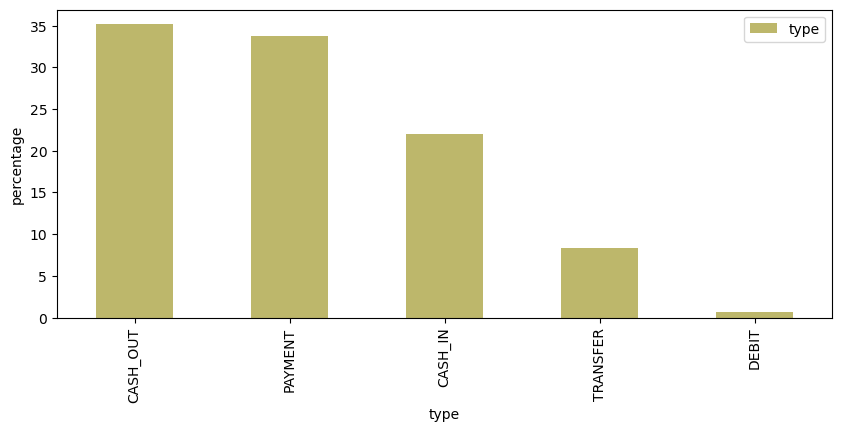

                                                   ISFRAUD


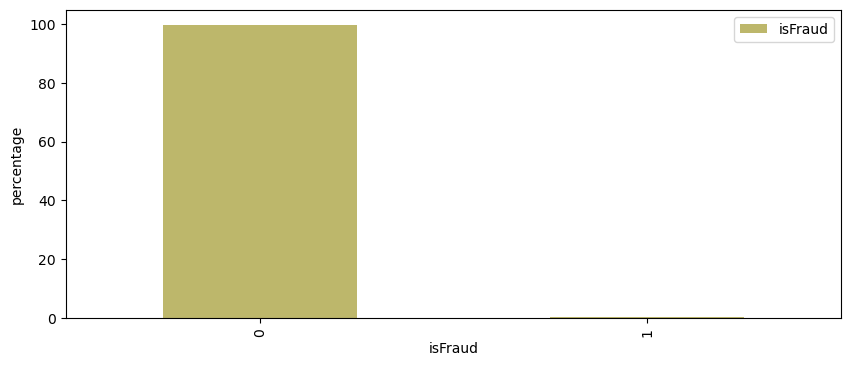

                                                   ISFLAGGEDFRAUD


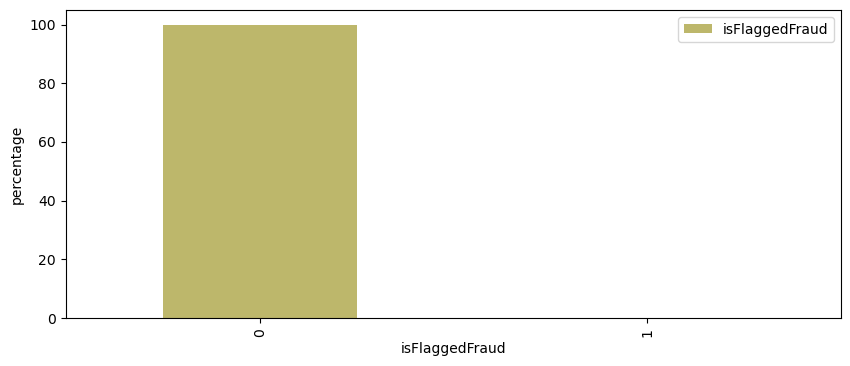

CPU times: total: 12.6 s
Wall time: 12.9 s


In [8]:
%%time
# value_counts

for i in df.columns:
    if df[i].nunique() < 58:
        print(' ' * 50, i.upper())
        pd.DataFrame(df[i].value_counts(normalize=True) * 100).plot(
            kind='bar', color='darkkhaki', figsize=(10, 4))
        plt.xlabel(i)
        plt.ylabel('percentage')
        plt.show()

***Count the occurrences of categories in percentage within a column that has a limited number of categories***


---

In [9]:
%%time 

# describe of numerical features
df.describe().T

CPU times: total: 1.7 s
Wall time: 1.73 s


,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [10]:
%%time 

# describe of catagorical features
df.describe(include='object').T

CPU times: total: 15.5 s
Wall time: 15.6 s


,count,unique,top,freq
type,6362620,5,CASH_OUT,2237500
nameOrig,6362620,6353307,C1902386530,3
nameDest,6362620,2722362,C1286084959,113


---


***_Describe of both numerical and object type data_***

---

**[Return to the index](#index)**


<a id='2.3'> </a>

## 2.3 Checking Missing  and Duplicate Values

In [11]:
%%time 

df.isnull().sum()

CPU times: total: 3.38 s
Wall time: 3.51 s


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
%%time 

df.duplicated().sum()

CPU times: total: 19.4 s
Wall time: 19.8 s


0

---


***No missing values and duplicate values are present in our data***


---

**[Return to the index](#index)**


<a id='2.4'> </a>

## 2.4 Visualization of outliers using boxplot and correlation using heatmap

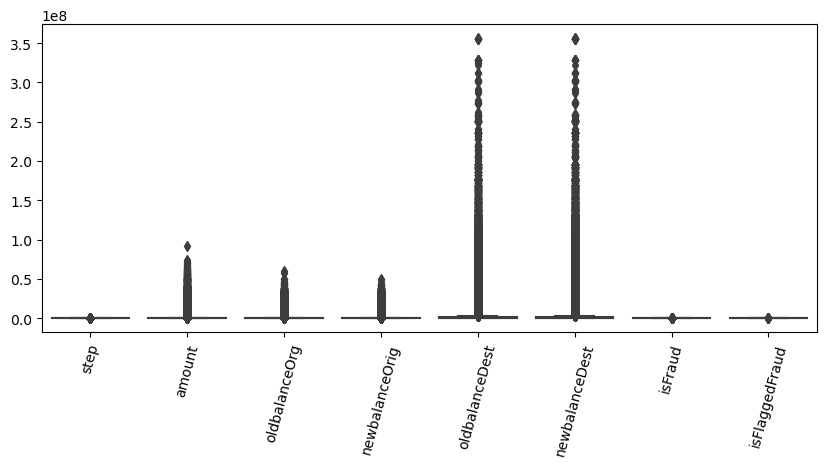

In [13]:
plt.figure(figsize=(10,4))
sns.boxplot(data = df)
plt.xticks(rotation=75)
plt.show()

- ***_Visualization of outliers_***


---

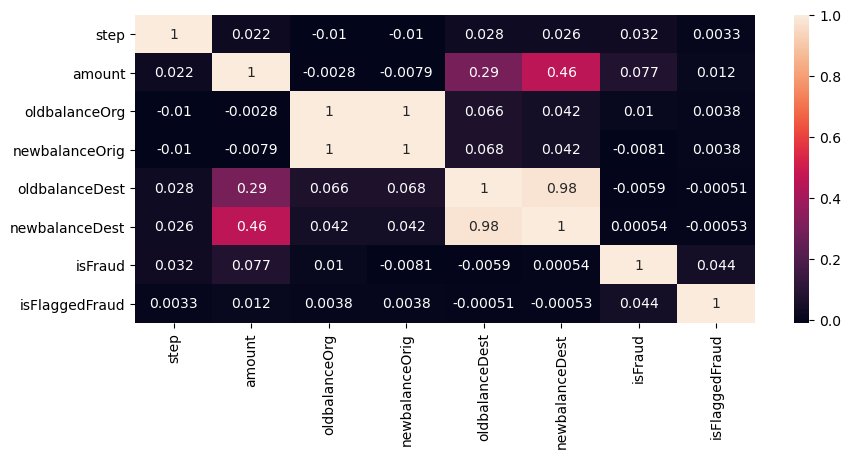

In [14]:

plt.figure(figsize=(10,4))
sns.heatmap(df.corr(),annot=True)
plt.show()

***_Observation based on the Correlation plot_***



- ```To simplify the model and reduce instability, the features "newbalanceDest" and "newbalanceOrig" will be removed because they have a correlation greater than 0.98 with other independent features and a low correlation with the target variable. By eliminating these highly correlated features, the model's complexity will be reduced, and the risk of overfitting will be decreased, leading to more stable and accurate predictions.```

---

**[Return to the index](#index)**


=============================================================================================================
<a id='3'></a>
# 3. Data Pre-processing  & Feature Engineering 

<a id='3.1'> </a>
## 3.1  Removing Features & Train Test Split 

In [15]:
df1 = df.copy()

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [16]:
df.drop(['newbalanceOrig','newbalanceDest'],axis=1,inplace=True)

In [17]:
%%time


# Train test split
X = df.drop('isFraud',axis=1)
y = df.isFraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

CPU times: total: 7.02 s
Wall time: 7.29 s


**[Return to the index](#index)**


<a id='3.2'> </a>

## 3.2 Encoding Categorical Columns & Data Oversampling

In [25]:
%%time

encoder = ce.TargetEncoder(return_df=True)
X_train = encoder.fit_transform(X_train,y_train)
X_test = encoder.transform(X_test)


CPU times: total: 3min 2s
Wall time: 3min 16s


In [26]:
%%time

from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE()

# Fit SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

CPU times: total: 4.81 s
Wall time: 5 s


In [27]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,nameDest,oldbalanceDest,isFlaggedFraud
5496416,380,0.001844,132254.09,0.001292,598531.00,3.473570e-04,0.00,0
1820142,163,0.000000,71191.05,0.001292,15375801.89,4.331286e-07,433424.62,0
2593229,207,0.007679,871751.20,0.001292,47743.00,2.427647e-15,5258038.41,0
2460153,203,0.000000,211557.34,0.001292,302452.22,8.644295e-06,338669.15,0
4896812,349,0.000000,34809.99,0.001292,6501.00,1.291571e-03,0.00,0


**[Return to the index](#index)**


<a id='3.3'> </a>

## 3.3 Visualization of target variable for train data 

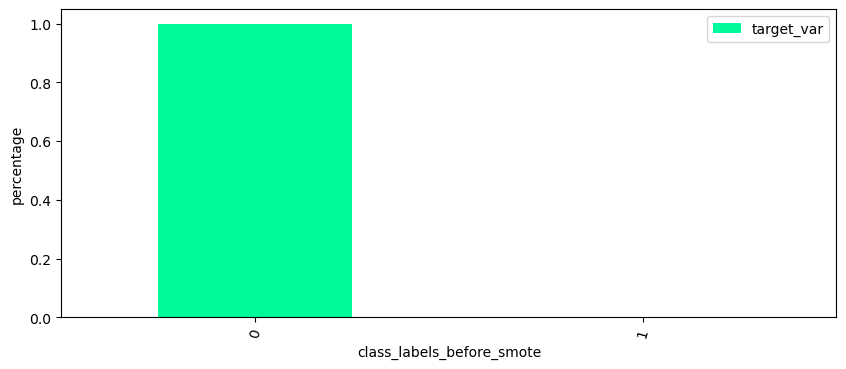

In [28]:
y_train.value_counts(normalize=True).reset_index().set_index('index').rename(columns={'isFraud':'target_var'}).plot(kind='bar',
                                               color='mediumspringgreen',
                                               figsize=(10, 4))
plt.xlabel('class_labels_before_smote')
plt.ylabel('percentage')
plt.xticks(rotation=75);

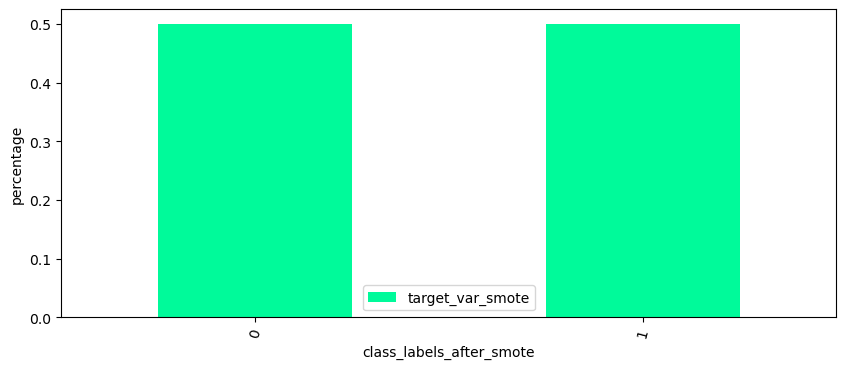

In [29]:
y_train_smote.value_counts(normalize=True).reset_index().set_index('index').rename(columns={'isFraud':'target_var_smote'}).plot(kind='bar',
                                               color='mediumspringgreen',
                                               figsize=(10, 4))
plt.xlabel('class_labels_after_smote')
plt.ylabel('percentage')
plt.xticks(rotation=75);

**[Return to the index](#index)**


<a id='3.4'> </a>

## 3.4 Effective Methods for Outlier Removal 

<a id='3.41'> </a>

### 3.41 DBSCAN

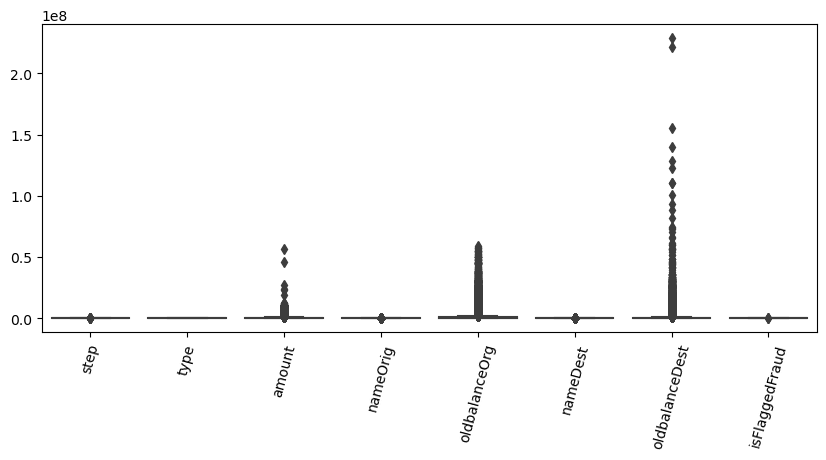

In [31]:
dbs_Xtrain = X_train_smote.copy(deep=True).sample(100000)
plt.figure(figsize=(10,4))
sns.boxplot(data=dbs_Xtrain)
plt.xticks(rotation=75)
plt.show()

In [32]:
# %%time

dbsc = DBSCAN(eps = 210, min_samples = 3).fit(dbs_Xtrain)

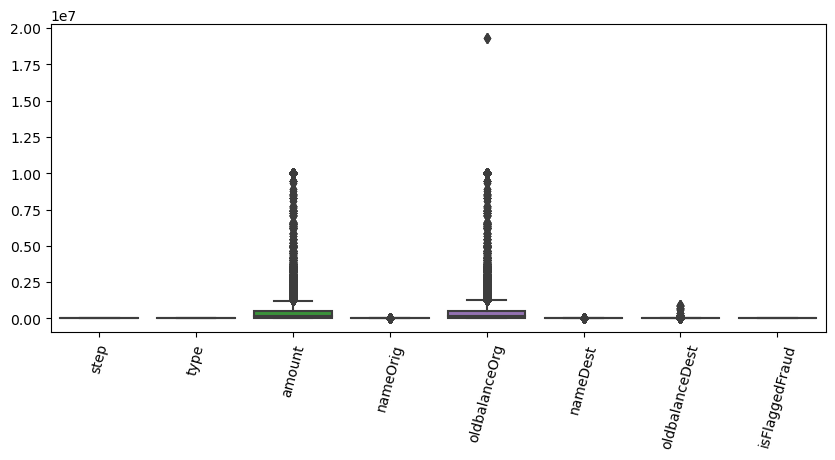

In [33]:

# Get the mask for the non-outlier points
non_outliers_mask = dbsc.labels_ != -1
non_outliers_db = dbs_Xtrain[non_outliers_mask]

# Create a boxplot of the non-outlier points
plt.figure(figsize=(10,4))
sns.boxplot(data=non_outliers_db)
plt.xticks(rotation=75)
plt.show()

In [34]:
len(non_outliers_db),len(dbs_Xtrain)

(32688, 100000)

**[Return to the index](#index)**


<a id='3.42'> </a>

### 3.42 Isolation Forest

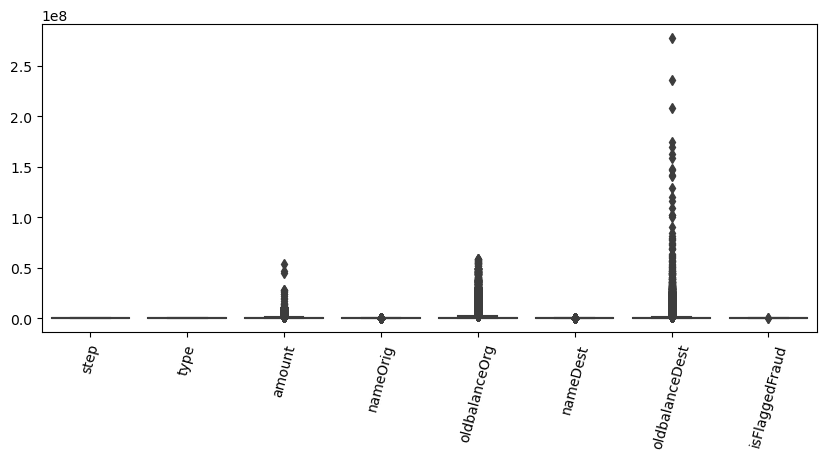

In [35]:
isf_Xtrain = X_train_smote.copy(deep=True).sample(100000)
plt.figure(figsize=(10,4))
sns.boxplot(data=isf_Xtrain)
plt.xticks(rotation=75)
plt.show()

In [36]:
%%time

isf = IsolationForest(contamination = 0.10, random_state=0, n_estimators=500).fit_predict(isf_Xtrain)

CPU times: total: 36.5 s
Wall time: 37 s


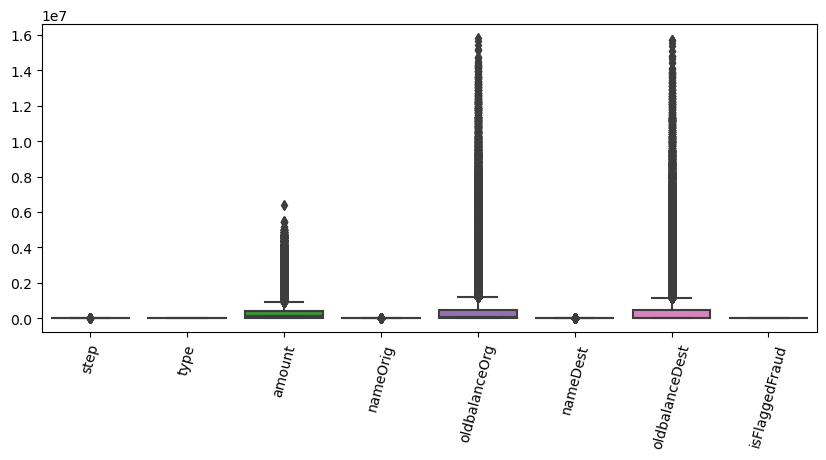

In [37]:
# Get the mask for the non-outlier points
non_outliers_mask = isf != -1
non_outliers_isf = isf_Xtrain[non_outliers_mask]

# Create a boxplot of the non-outlier points
plt.figure(figsize=(10,4))
sns.boxplot(data=non_outliers_isf)
plt.xticks(rotation=75)
plt.show()

In [38]:
len(non_outliers_isf),len(isf_Xtrain)

(90000, 100000)

**[Return to the index](#index)**

<a id='3.43'> </a>

### 3.43 Local Outlier Factor

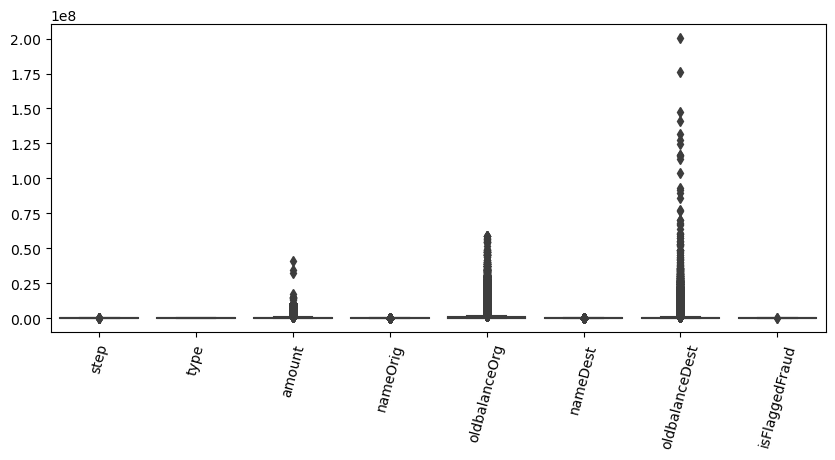

In [39]:
lof_Xtrain = X_train_smote.copy(deep=True).sample(100000)
plt.figure(figsize=(10,4))
sns.boxplot(data=lof_Xtrain)
plt.xticks(rotation=75);

In [40]:
%%time

lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10).fit_predict(lof_Xtrain)

CPU times: total: 1.88 s
Wall time: 1.87 s


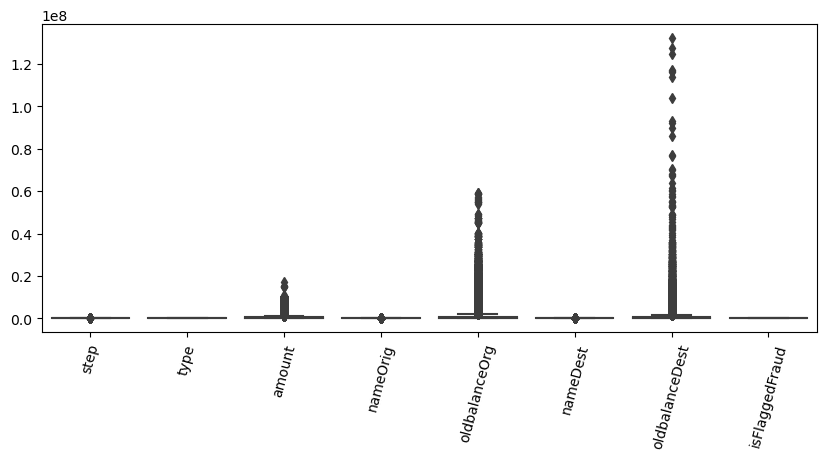

In [41]:
# Get the mask for the non-outlier points
non_outliers_mask = lof != -1
non_outliers_lof = lof_Xtrain[non_outliers_mask]

# Create a boxplot of the non-outlier points
plt.figure(figsize=(10,4))
sns.boxplot(data=non_outliers_lof)
plt.xticks(rotation=75);

In [42]:
len(non_outliers_lof),len(lof_Xtrain)

(90000, 100000)

**[Return to the index](#index)**

<a id='3.44'> </a>

### 3.34 IQR Method

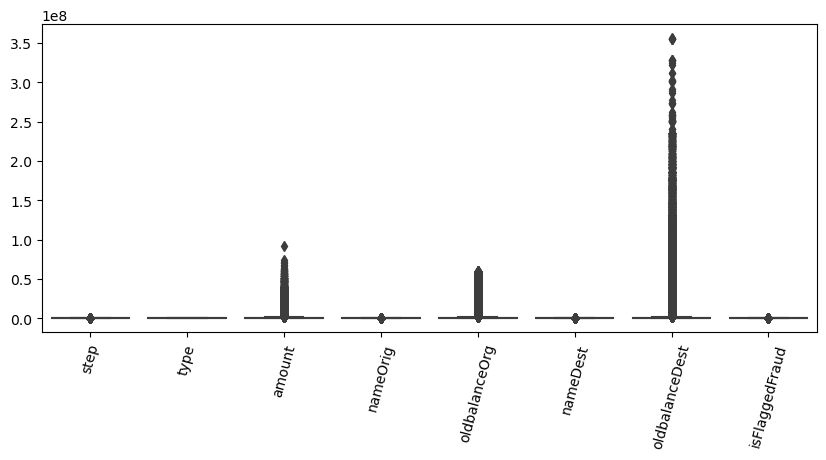

In [43]:
iqr_X = X_train_smote.copy(deep=True)
plt.figure(figsize=(10,4))
sns.boxplot(data=iqr_X)
plt.xticks(rotation=75);

In [44]:
def outlier_removal_with_iqr(iqr_X,i):
    q1 = iqr_X[i].quantile(.25) 
    q3 = iqr_X[i].quantile(.75) 
    iqr = q3 - q1
    max_ = q3 + 1.5*iqr
    min_ = q1 - 1.5*iqr
    return iqr_X[i].clip(min_,max_)

In [45]:
%%time

# removing outliers
for i in iqr_X.columns:
    iqr_X[i]=outlier_removal_with_iqr(iqr_X,i)

CPU times: total: 6.98 s
Wall time: 5.94 s


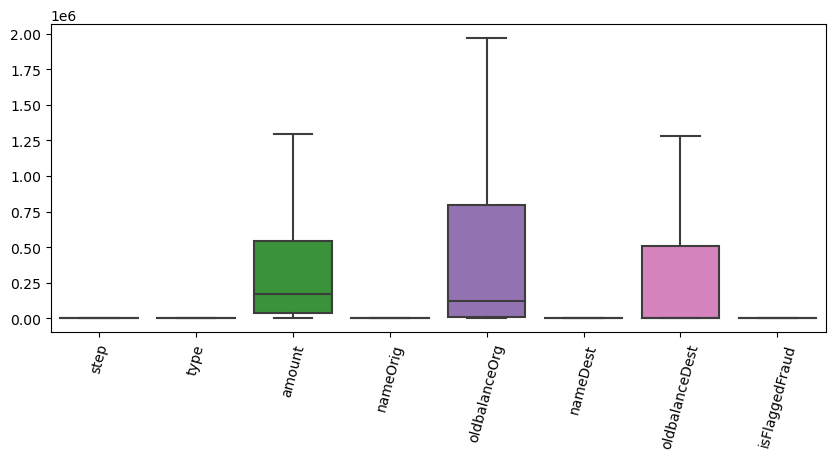

In [46]:
plt.figure(figsize=(10,4))
sns.boxplot(data=iqr_X)
plt.xticks(rotation=75);

In [47]:
len(iqr_X),len(X_train_smote)

(11437924, 11437924)

***No data reduction***

In [48]:
iqr_X.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
nameDest          0
oldbalanceDest    0
isFlaggedFraud    0
dtype: int64

***No missing values after removing outliers***

In [49]:
iqr_X.isin([np.inf, -np.inf]).sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
nameDest          0
oldbalanceDest    0
isFlaggedFraud    0
dtype: int64

***No infinite values after removing outliers***

**[Return to the index](#index)**

<a id='4'> </a>

# 4. Creating Base Model

In [50]:
y_train_smote.sample(100000).value_counts()

1    50017
0    49983
Name: isFraud, dtype: int64

In [84]:
df_small = pd.concat([X_train_smote, y_train_smote],axis=1).sample(5000000)
df_small.to_csv('RSCV_Outlier1.csv')
X_train_s = df_small.drop('isFraud',axis=1)
y_train_s = df_small['isFraud']

In [85]:
df_small_iqr = pd.concat([iqr_X, y_train_smote],axis=1).sample(5000000)
df_small_iqr.to_csv('RSCV_noOutlier1.csv')
X_train_s_iqr = df_small_iqr.drop('isFraud',axis=1)
y_train_s_iqr = df_small_iqr['isFraud']

In [53]:
def metric(y_test, y_pred):

    print('Precision :',precision_score(y_test, y_pred),'\n')
    print('Recall :',recall_score(y_test, y_pred),'\n')
    print('Accuracy :',accuracy_score(y_test, y_pred),'\n')
    print('F1 Score :',f1_score(y_test, y_pred),'\n')
#     print('Precision :',precision_score(y_test, y_pred),'\n')

<a id='4.1'> </a>

## 4.1 Base Model without outliers

In [96]:
%%time


clf = RandomForestClassifier(max_depth=18, random_state=42,n_estimators=265,n_jobs=-1,bootstrap=True,min_samples_split=905,min_samples_leaf=2370,max_samples=0.1)
clf.fit(X_train_s_iqr, y_train_s_iqr)

CPU times: total: 16min
Wall time: 4min 30s


RandomForestClassifier(max_depth=18, max_samples=0.1, min_samples_leaf=2370,
                       min_samples_split=905, n_estimators=265, n_jobs=-1,
                       random_state=42)

In [98]:
%%time

y_pred = clf.predict(X_test)

CPU times: total: 22.4 s
Wall time: 6.09 s


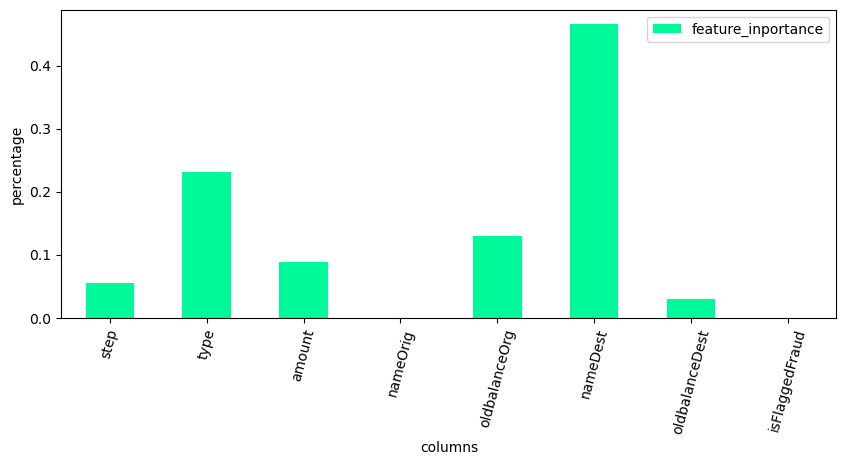

In [99]:

((pd.DataFrame(clf.feature_importances_.reshape(-1, 1).T,
              columns=X_train_smote.columns).T).rename(columns={0:'feature_inportance'})).plot(kind='bar',
                                               color='mediumspringgreen',
                                               figsize=(10, 4))
plt.xlabel('columns')
plt.ylabel('percentage')
plt.xticks(rotation=75);

In [100]:
print('Train Accuracy Score',accuracy_score(y_train_s_iqr,clf.predict(X_train_s_iqr)),'\n')

metric(y_test, y_pred)

Train Accuracy Score 0.9949982 

Precision : 0.04914436156208864 

Recall : 0.4112607099143207 

Accuracy : 0.9890265330948571 

F1 Score : 0.08779723020642802 



In [101]:
y_proba = clf.predict_proba(X_test)

In [135]:
def custom_predict(X, threshold):
        probs = clf.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    
def custom_predict1(X, threshold):
        probs = clf1.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)

In [136]:
threshold = 0.95

y_pred_thres =custom_predict(X_test,threshold)
metric(y_test, y_pred_thres)

Precision : 0.6254545454545455 

Recall : 0.21052631578947367 

Accuracy : 0.9988243836658484 

F1 Score : 0.315018315018315 



- ###  ***In our business case, achieving the highest level of precision is crucial. Therefore, we have attempted to identify the optimal threshold that would help us attain this precision.***

---
***_Score of Base Model without Outliers_***

---

**[Return to the index](#index)**

<a id='4.2'> </a>
## 4.2 Base Model with outliers

In [97]:
%%time

clf1 = RandomForestClassifier(max_depth=18, random_state=42,n_estimators=265,n_jobs=-1,bootstrap=True,min_samples_split=905,min_samples_leaf=2370,max_samples=0.1)
clf1.fit(X_train_s, y_train_s)

CPU times: total: 15min 31s
Wall time: 4min 14s


RandomForestClassifier(max_depth=18, max_samples=0.1, min_samples_leaf=2370,
                       min_samples_split=905, n_estimators=265, n_jobs=-1,
                       random_state=42)

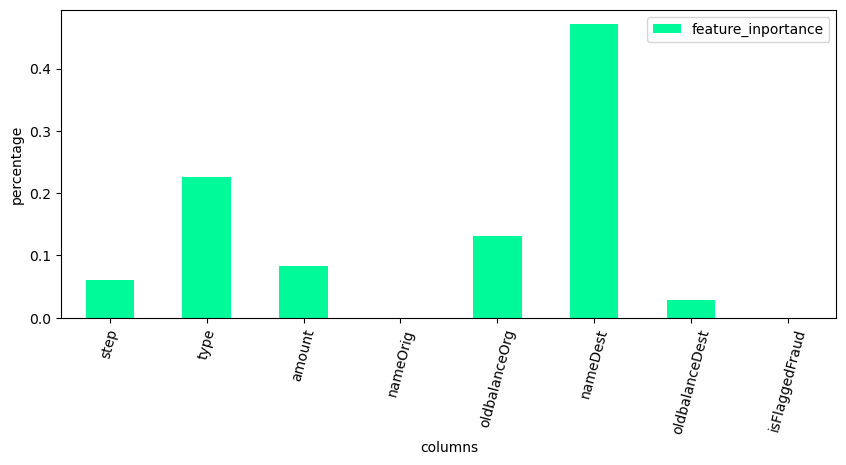

In [104]:
((pd.DataFrame(clf1.feature_importances_.reshape(-1, 1).T,
              columns=X_train.columns).T).rename(columns={0:'feature_inportance'})).plot(kind='bar',
                                               color='mediumspringgreen',
                                               figsize=(10, 4))
plt.xlabel('columns')
plt.ylabel('percentage')
plt.xticks(rotation=75);

In [105]:
y_pred1 = clf1.predict(X_test)

In [106]:
%%time
print('Train Accuracy Score',accuracy_score(y_train_s,clf.predict(X_train_s)),'\n')

metric(y_test, y_pred1)

Train Accuracy Score 0.9950084 

Precision : 0.04488545551411827 

Recall : 0.412484700122399 

Accuracy : 0.9879750794484033 

F1 Score : 0.08096096096096096 

CPU times: total: 3min 36s
Wall time: 1min 4s


In [149]:
threshold = 0.93

y_pred_thres1 =custom_predict1(X_test,threshold)
metric(y_test, y_pred_thres1)

Precision : 0.8777777777777778 

Recall : 0.0966952264381885 

Accuracy : 0.9988228119862572 

F1 Score : 0.17420066152149943 



- ### ***In our business case, achieving the highest level of precision is crucial. Therefore, i have attempted to identify the optimal threshold that would help us attain this precision.***

---
***_Score of Base Model with Outliers_***

---

**[Return to the index](#index)**

<a id='4.3'> </a>


## 4.3 KFold Crossvalidation & Randomsearch CV

In [107]:
from sklearn.metrics import f1_score

def f1_scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    return f1_score(y, y_pred)

In [108]:
%%time

kf = KFold(n_splits=5,shuffle=True,random_state=42)

CPU times: total: 0 ns
Wall time: 0 ns


In [109]:
%%time

score = cross_val_score(clf,X_train_s_iqr,y_train_s_iqr,cv=kf,scoring=f1_scoring,n_jobs=-1)

CPU times: total: 2 s
Wall time: 22min 17s


In [110]:
score

array([0.9949535 , 0.9947568 , 0.99482177, 0.99497312, 0.99483527])

In [111]:
print("mean_scores :",score.mean(),'\n')
print("standard_dev_scores :",score.std(),'\n')

mean_scores : 0.9948680929980818 

standard_dev_scores : 8.238480927640354e-05 



**[Return to the index](#index)**

---

***Hyperparameter Tuning with Random-search CV***

In [71]:
%%time

from sklearn.model_selection import RandomizedSearchCV


param_dist = {"n_estimators": [50,100,150,200],
              "max_depth": [ 5, 7, 9,13,15],
             "max_samples":[0.1,0.2,0.3]
              "bootstrap": [True],

}


rf = RandomForestClassifier(n_jobs=-1,random_state=42,bootstrap=True,max_samples=0.2)

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=5, n_jobs=-1,random_state=42,scoring=f1_scoring)


random_search.fit(X_train_s,y_train_s)


print("Best hyperparameters: ", random_search.best_params_)

**After Hyperparameter Tuning** ```Best hyperparameters with 5lakh data:  {'n_estimators': 200, 'min_samples_split': 500, 'min_samples_leaf': 1000, 'max_depth': 9}```
- CPU times: user 53.2 s, sys: 771 ms, total: 54 s
Wall time: 13min 22s





**After FineTuning 1** ```Best hyperparameters with 5lakh data :  {'n_estimators': 300, 'min_samples_split': 1000, 'min_samples_leaf': 2000, 'max_depth': 13}```
- CPU times: user 1min 26s, sys: 1.38 s, total: 1min 27s
Wall time: 24min 56s






**After FineTuning 2** ```Best hyperparameters:  {'n_estimators': 250, 'min_samples_split': 1000, 'min_samples_leaf': 2500, 'max_depth': 17}```
- CPU times: user 1min 10s, sys: 1.32 s, total: 1min 12s
Wall time: 30min 42s






**After FineTuning 3** ```Best hyperparameters:  {'n_estimators': 270, 'min_samples_split': 900, 'min_samples_leaf': 2400, 'max_depth': 17}```
- CPU times: user 1min 8s, sys: 1.18 s, total: 1min 9s
Wall time: 24min 4s







**After FineTuning 4** ```Best hyperparameters:  {'n_estimators': 265, 'min_samples_split': 900, 'min_samples_leaf': 2400, 'max_depth': 18}```
- CPU times: user 1min 7s, sys: 1.55 s, total: 1min 9s
Wall time: 27min 46s





**After FineTuning 5** ```Best hyperparameters:  {'n_estimators': 265, 'min_samples_split': 905, 'min_samples_leaf': 2370, 'max_depth': 18}```
 - CPU times: user 1min 22s, sys: 1.65 s, total: 1min 24s
Wall time: 27min 45s




----



<a id='5'> </a>

# 5. Sequential Neural Network Using Keras & TensorFlow

<a id='5.1'> </a>

## 5.1 Scaling data with standard scaler

In [73]:
X_train_smote_iqr = iqr_X.copy()

In [74]:
%%time

# Normalizing train data 
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train_smote_iqr)
X_train_scaler = pd.DataFrame(X_train_scaler ,columns=X_test.columns)

# # Transforming test data 
X_test_scaler = scaler.transform(X_test)
X_test_scaler = pd.DataFrame(X_test_scaler ,columns=X_train.columns)

CPU times: total: 3.03 s
Wall time: 4.92 s


**[Return to the index](#index)**

<a id='5.2'> </a>

## 5.2 Building Model Architecture

In [75]:
def build_model():
    model = keras.Sequential([
        layers.Dense(18, activation=tf.nn.swish, input_shape=[len(X_train_smote.keys())]),
        layers.Dense(36, activation=tf.nn.swish),
        layers.Dense(72, activation=tf.nn.swish),
        layers.Dropout(0.2),
        layers.Dense(144, activation=tf.nn.swish),
        layers.Dense(288, activation=tf.nn.swish),
        layers.Dropout(0.1),
        layers.Dense(144, activation=tf.nn.swish),
        layers.Dense(72, activation=tf.nn.swish),
        layers.Dropout(0.1),
        layers.Dense(36, activation=tf.nn.swish),
        layers.Dense(18, activation=tf.nn.swish),

        layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    
    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.Accuracy()])
    return model

In [76]:
model = build_model()
model1 = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                162       
                                                                 
 dense_1 (Dense)             (None, 36)                684       
                                                                 
 batch_normalization (BatchN  (None, 36)               144       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 72)                2664      
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_3 (Dense)             (None, 144)               10512     
                                                        

**[Return to the index](#index)**

<a id='5.3'> </a>

## 5.3 Model with outliers

In [77]:
%%time

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # create the EarlyStopping callback
# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:print('')
        print('.',end='')
EPOCHS = 20


# model training
history = model.fit(
X_train_smote,y_train_smote,
epochs=EPOCHS, validation_split=0.2,verbose=0,
callbacks=[model_checkpoint, PrintDot()],batch_size=128,workers=-1)


....................CPU times: total: 8h 53min 17s
Wall time: 4h 5min 17s


In [120]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist['f1_score']= 2*(hist['precision']*hist['recall'])/(hist['precision']+hist['recall'])
hist['val_f1_score']= 2*(hist['val_precision']*hist['val_recall'])/(hist['val_precision']+hist['val_recall'])
hist.tail()

,loss,precision,recall,accuracy,val_loss,val_precision,val_recall,val_accuracy,epoch,f1_score,val_f1_score
15,0.016240,0.995407,0.993551,0.003989,0.090978,1.0,0.972986,0.026937,15,0.994478,0.986308
16,0.015712,0.995748,0.993913,0.004763,0.211888,1.0,0.905781,0.000151,16,0.994830,0.950562
17,0.015606,0.995570,0.993967,0.007760,0.336222,1.0,0.905373,0.000000,17,0.994768,0.950337
18,0.014704,0.995821,0.994320,0.007251,0.027657,1.0,0.994129,0.012739,18,0.995070,0.997056
19,0.016070,0.995080,0.993976,0.005680,3.201990,1.0,0.346506,0.000078,19,0.994527,0.514675


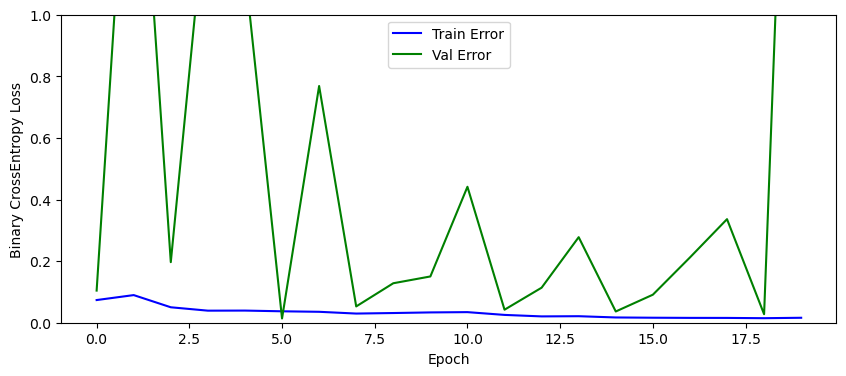

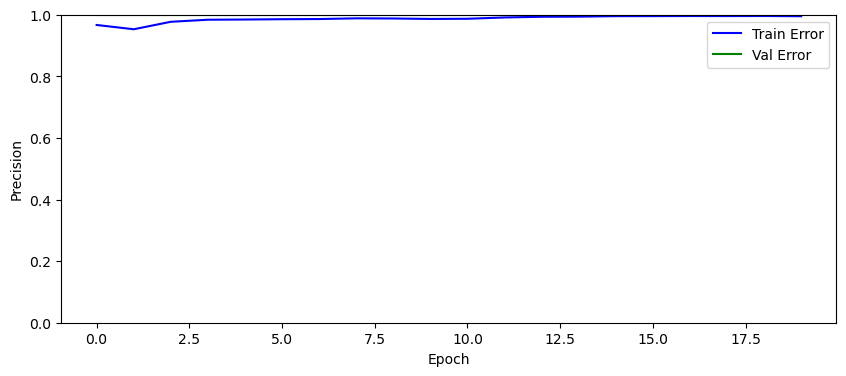

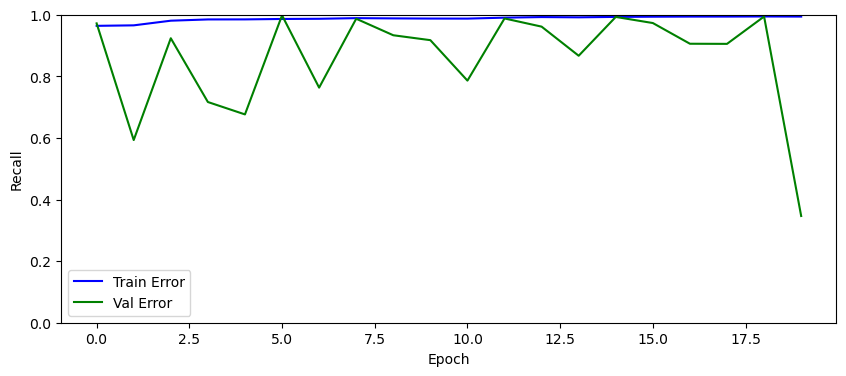

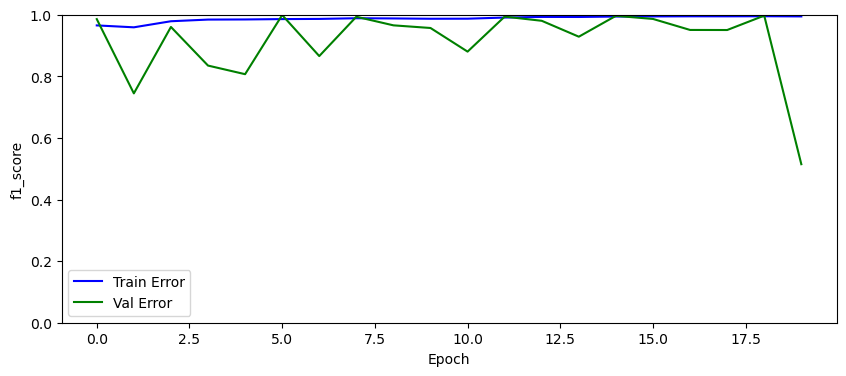

In [121]:
def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch
#     hist['rmse'] = np.sqrt(hist.mse)
#     hist['val_rmse'] = np.sqrt(hist.val_mse)
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Error',color='b')
    plt.plot(hist['epoch'], hist['val_loss'],
         label='Val Error',color='g')
    plt.legend()
    plt.ylim([0,1])
    
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.plot(hist['epoch'], hist['precision'],
             label='Train Error',color='b')
    plt.plot(hist['epoch'], hist['val_precision'],
         label='Val Error',color='g')
    plt.legend()
    plt.ylim([0,1])
    
    
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.plot(hist['epoch'], hist['recall'],
             label='Train Error',color='b')
    plt.plot(hist['epoch'], hist['val_recall'],
         label='Val Error',color='g')
    plt.legend()
    plt.ylim([0,1])
    
    
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epoch')
    plt.ylabel('f1_score')
    plt.plot(hist['epoch'], hist['f1_score'],
             label='Train Error',color='b')
    plt.plot(hist['epoch'], hist['val_f1_score'],
         label='Val Error',color='g')
    plt.legend()
    plt.ylim([0,1])
plot_history(history)

In [79]:
model.load_weights('model.h5')

19884/19884 [==============================] - 63s 3ms/step


**[Return to the index](#index)**

<a id='5.4'> </a>

# 5.4 Leading Questions:

<a id='5.5.1'> </a>

### 5.5.1 Data cleaning including missing values, outliers and multi-collinearity.

**Missing Values:** ```The dataset provided is complete and does not contain any missing values.```




**Outliers:** ```After trying various outlier detection methods such as DBSCAN, Local Outlier Factor, and Isolation Forest,IQR on a dataset with a large number of outliers, I found that the IQR (Interquartile Range) method worked best. I confirmed this by visualizing the outliers using a box plot. I then clipped the outliers using the IQR method, which means I truncated the values outside the upper and lower bounds defined by the IQR. By doing this, I was able to retain all of the original data points, while removing the outliers that were identified using the IQR method.```


**Multi-collinearity:** ```To address the issue of multicollinearity and improve the model's stability, i have decided to remove the features "newbalanceDest" and "newbalanceOrig". These features exhibit a high degree of correlation (greater than 0.98) with other independent variables in the dataset, which can lead to numerical instability and overfitting. Additionally, these features have a low correlation with the target variable, and their removal will not have a significant impact on the model's predictive performance. By eliminating these highly correlated features, i can reduce the model's complexity and improve its reliability and accuracy.```

<a id='5.5.2'> </a>

### 5.5.2 Describe your fraud detection model in elaboration.

```Developed a fraud detection model to address the rising problem of fraudulent transactions, using supervised learning techniques and neural networks in machine learning. The model focuses on detecting and catching fraudulent transactions, helping to mitigate the risk of financial losses and protect against fraudulent activities.The resulting model can help businesses and organizations identify and prevent fraudulent transactions, improving overall security and trust.```



***Specific approach and techniques used to develop the model includes:***


$Problem Statement, Importing Modules & Data Import :-$ ```As part of my model building process, I first explained the problem statement and provided data dictionaries to ensure a clear understanding of the data. I then imported the required modules for building the model. When importing the data from a CSV format, it took 20.1 seconds, which was quite long. To optimize the importing process, I converted the data to a Parquet format using fastparquet. This reduced the importing time to 9.72 seconds, which will be useful for future data importing tasks.```


$Exploratory Data Analysis  & Visualizations :-$ ```During my exploratory data analysis, I checked the shape, number of unique values, and data types of all the features. I also explored the proportion of each category using value counts and checked for outliers using the describe function. After verifying that there were no missing or duplicate values, I plotted visualizations to investigate outliers and correlations between features.```


```During the analysis, I identified two independent variables that had a correlation greater than 0.98. These features had low correlation with the target variable and could potentially cause instability in the model. Therefore, I decided to remove these features from the dataset. By eliminating these highly correlated features, the model's complexity will be reduced, and the risk of overfitting will be decreased, leading to more stable and accurate predictions.``` 

$Data Pre-processing &  Feature Engineering :-$ ```Following the removal of highly correlated independent features and the creation of a train-test split, i target encoded the categorical columns using target encoding and employed SMOTE to oversample the minority class. Subsequently, i generated a visualization of the distribution of the target variable and produced four boxplots of the features after eliminating outliers with four different techniques: DBScan, Isolation Forest, Local Outlier Factor, and IQR. After careful consideration, i determined that the IQR method was the best approach since it allowed us to prevent any reduction of data by clipping the outliers.```


$Creation of Base Model & Hyperparameter Training :-$ ```I developed a base model using random forest, which can process data more quickly than gradient boosting machine (GBM) algorithms, on both the outlier and non-outlier data. I employed k-fold cross-validation with F1 score as the scoring metric, and conducted hyperparameter tuning using random search CV since it is faster than grid search CV. Additionally, I fine-tuned the hyperparameters using random search CV and produced visualizations of the feature importances for both models.```



$Building Neural Network Architecture & Model Training with Neural Networks :-$  ```I scaled the data using a standard scaler and constructed a neural network architecture that comprised a total of 112,591 parameters. I trained the model using the entire dataset and implemented callbacks such as printdot and model checkpoint to track its progress. The training process lasted for approximately five hours and was implemented using the Keras TensorFlow library. I also generated visualizations of all epochs, which displayed metrics such as precision, recall, and accuracy for both the training and validation sets.```



$Leading questions & Conclusion :-$  ```I addressed all the questions related to the project by utilizing brief explanations and visualizations. In the concluding paragraph, I summarized what could have been done to improve the model's accuracy and prevent fraud to users if additional time had been available.``` 

<a id='5.5.3'> </a>

### 5.5.3 How did you select variables to be included in the model?

```When building a neural network model, I ensured that the dataset was free of missing or duplicate values and addressed the issue of multicollinearity by removing highly correlated features. Since neural networks are capable of performing automatic feature selection, I passed the preprocessed data directly to the model without explicitly selecting or engineering any additional features. By doing so, I allowed the neural network to learn the most relevant features and patterns from the input data, leading to more accurate and efficient predictions.```

**[Return to the index](#index)**

<a id='5.5.4'> </a>

### 5.5.4 Demonstrate the performance of the model by using best set of tools

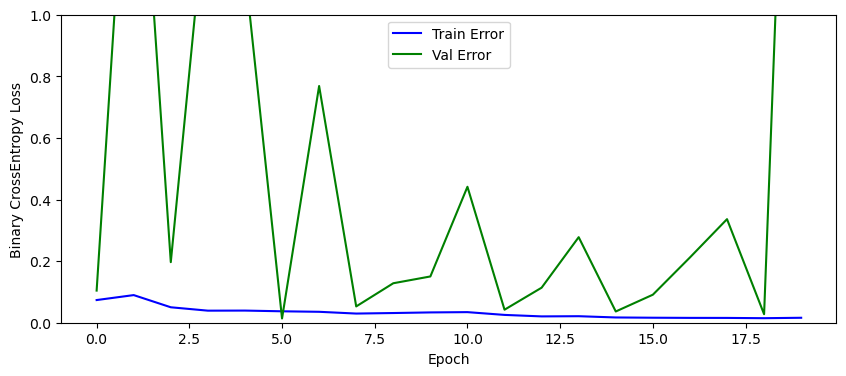

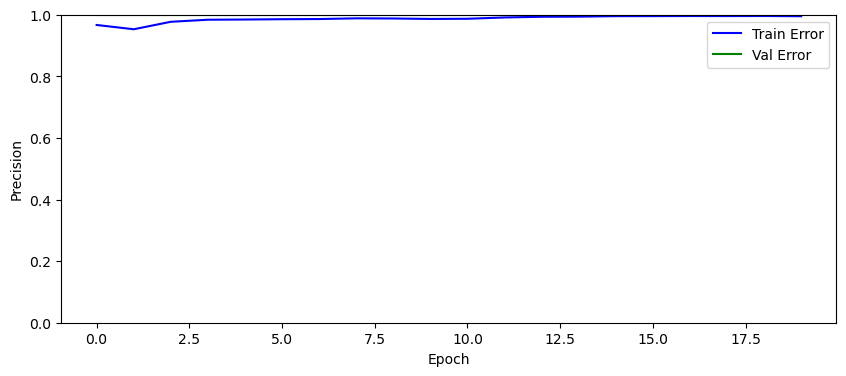

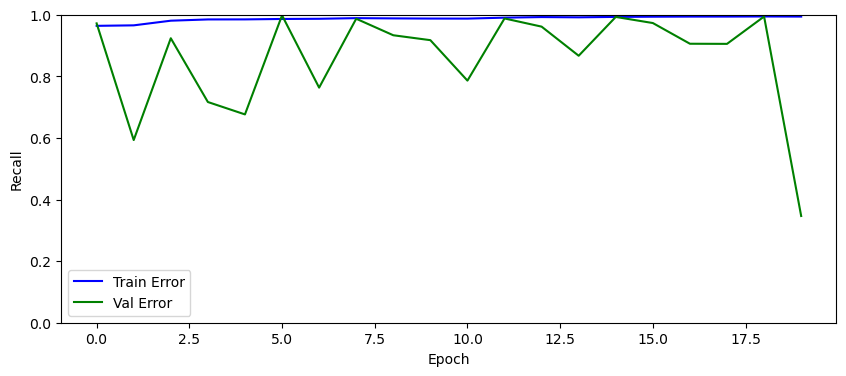

In [86]:
plot_history(history)

<a id='5.5.5'> </a>

### 5.5.5 What are the key factors that predict fraudulent customer?

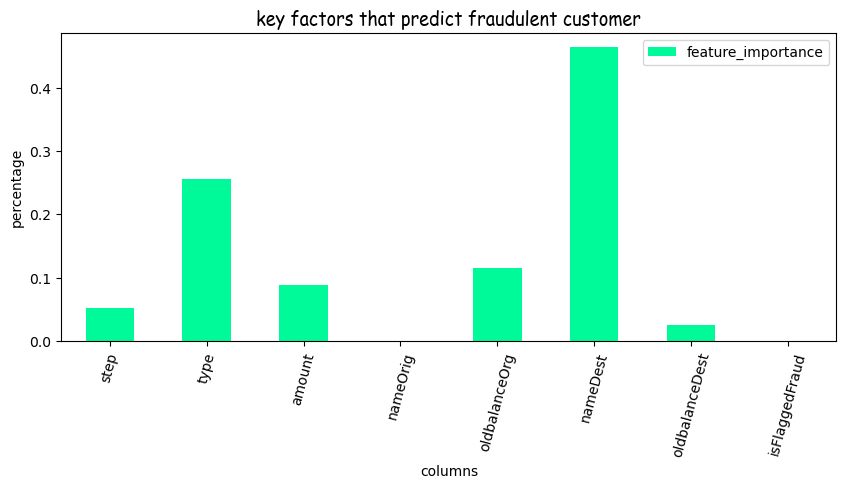

In [87]:
((pd.DataFrame(clf1.feature_importances_.reshape(-1, 1).T,
              columns=X_train.columns).T).rename(columns={0:'feature_importance'})).plot(kind='bar',
                                               color='mediumspringgreen',
                                               figsize=(10, 4))
plt.xlabel('columns')
plt.ylabel('percentage')
plt.xticks(rotation=75)
plt.title(
'key factors that predict fraudulent customer',
fontsize=13,
fontname='Comic Sans MS');

<a id='5.5.6'> </a>

### 5.5.6 Do these factors make sense? If yes, How? If not, How not?

```The most crucial factor in detecting fraudulent transactions is the transaction amount. This is because fraudsters typically attempt to extract the maximum amount of money possible during a fraudulent transaction. Therefore, the transaction amount is highly indicative of potential fraud. On the other hand, the "isFlaggedFraud" feature has the least impact on predicting fraudulent transactions. This is because it is possible that legitimate transactions exceed the threshold for this flag. As a result, we cannot definitively assume that transactions over 200,000 are fraudulent. All other features have a more or less equal contribution to identifying fraudulent transactions, and their inclusion in the model is important for accurate and effective fraud detection.```

<a id='5.5.7'> </a>

### 5.5.7 What kind of prevention should be adopted while company update its infrastructure?

**Data storage and processing:** ```To detect fraud, organizations need to collect and process large amounts of data from various sources such as transactional data, user behavior data, and historical data. This requires reliable data storage and processing infrastructure, such as data warehouses and data lakes.```


**Machine learning and artificial intelligence**: ```Machine learning algorithms and artificial intelligence systems can be used to detect fraud by identifying patterns and anomalies in data that may not be apparent to humans. These systems require powerful hardware infrastructure and specialized software frameworks such as TensorFlow or PyTorch.```


**Real-time monitoring:** ```Fraud can occur in real-time, and so organizations need to be able to monitor transactions and user behavior in real-time as well. This requires real-time monitoring infrastructure that can quickly process large amounts of data and alert fraud detection teams of suspicious activity.```

**[Return to the index](#index)**

<a id='5.5.8'> </a>

### 5.5.8. Assuming these actions have been implemented, how would you determine if they work?

```After implementing the fraud detection infrastructure, we would collect real-time data to identify anomalies and vulnerabilities in transactions. Using this data, we would create scores or thresholds to quantify the likelihood of a transaction being fraudulent. This would help prevent fraud by prompting users for verification of suspicious transactions, especially if the transaction amount is large. To minimize the number of verification calls, we would make a limited number of calls based on the score or threshold.```

```If fraud still occurs, we would use the infrastructure to prevent multiple attacks on the same user account. For example, we would automatically block any further transactions or activities associated with a compromised account until the user confirms their identity.```

```All of these prevention measures require powerful infrastructure and specialized software capable of monitoring real-time data. With the right infrastructure in place, we can effectively prevent and detect fraud, protecting our customers' financial information and enhancing their overall customer experience.```

<a id='6'> </a>

# 6. Conclusion

```If more time had been given for the project, there are several additional tasks that could have been explored to potentially improve the fraud detection model. For example, cluster analysis could have been performed to divide the data into clusters based on nearest neighbors and determine which clusters provide the most accurate predictions for fraud detection. Additionally, more hyperparameters could have been included in the random search for hyperparameter tuning, which could potentially lead to better performing models.```

```Other potential areas for improvement include training the model with higher epochs and trainable parameters, which could allow the model to learn more complex patterns and potentially improve its predictive performance. Overall, there are many potential avenues for improving the fraud detection model, and more time and resources would allow for a more comprehensive exploration of these options.```

```Despite these limitations, the current project provides a solid foundation for future work on fraud detection and demonstrates the effectiveness of machine learning in detecting fraudulent transactions. With further refinement and optimization, the model developed in this project has the potential to be a valuable tool in preventing fraud and protecting businesses and individuals from financial losses.```

**[Return to the index](#index)**

***END***
---